## Rate plots down currents. Several iterations with final rate+CI error bar plots at the bottom

In [ ]:
# %matplotlib qt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from shapely.geometry import LineString, Point, MultiPoint, GeometryCollection, MultiLineString
from shapely.ops import unary_union
from pyproj import Geod
from scipy.interpolate import interp1d
from cartopy import crs
from cartopy.feature import NaturalEarthFeature

import warnings
warnings.filterwarnings("ignore")

OUTPATH = './output'
IOPATH = '/ocean/ghoeven/MOAD/Data/PNWCurrent_obs.csv'

## Loading Data and Indicators

In [5]:
obs = pd.read_csv(IOPATH)
for col, count in obs.count().items():
    print(f"{col}: {count} non-NaN values")
obs

Unnamed: 0.1: 937232 non-NaN values
Unnamed: 0: 937232 non-NaN values
time: 937232 non-NaN values
longitude (degrees_east): 937232 non-NaN values
latitude (degrees_north): 937232 non-NaN values
depth (m): 937232 non-NaN values
pressure (dbar): 937232 non-NaN values
temperature (degC): 773348 non-NaN values
salinity (g kg-1): 916970 non-NaN values
DO (umol kg-1): 649238 non-NaN values
NO3 (uM): 219875 non-NaN values
NO2 (uM): 183089 non-NaN values
NH4 (uM): 4158 non-NaN values
PO4 (uM): 218083 non-NaN values
SiO4 (uM): 37458 non-NaN values
Chl (mg m-3): 27684 non-NaN values
TA (uM): 6078 non-NaN values
DIC (uM): 6077 non-NaN values
Carbonate: 1730 non-NaN values
Aragonite: 5191 non-NaN values
Calcite: 5191 non-NaN values
Cd (nmol kg-1): 87 non-NaN values
Co (nmol kg-1): 87 non-NaN values
Cu (nmol kg-1): 87 non-NaN values
Fe (nmol kg-1): 87 non-NaN values
Mn (nmol kg-1): 87 non-NaN values
Ni (nmol kg-1): 87 non-NaN values
Zn (nmol kg-1): 87 non-NaN values
source: 937232 non-NaN values
Ns

,Unnamed: 0.1,Unnamed: 0,time,longitude (degrees_east),latitude (degrees_north),depth (m),pressure (dbar),temperature (degC),salinity (g kg-1),DO (umol kg-1),...,spice,current,geometry,location,month,year,salinity (psu),density (kg m-3),is_offshore100,TA-DIC (uM)
0,0,1271,1933-07-25 00:00:00+00:00,-126.76,49.34,1.0,1.008587,NaN,32.070847,NaN,...,NaN,Shelf_Current,POINT (-126.76 49.34),shelf,7,1933,31.920329,NaN,False,NaN
1,1,1272,1933-07-25 00:00:00+00:00,-126.76,49.34,2.0,2.017180,NaN,32.090943,NaN,...,NaN,Shelf_Current,POINT (-126.76 49.34),shelf,7,1933,31.940330,NaN,False,NaN
2,2,1273,1933-07-25 00:00:00+00:00,-126.76,49.34,4.0,4.034378,NaN,32.090906,NaN,...,NaN,Shelf_Current,POINT (-126.76 49.34),shelf,7,1933,31.940294,NaN,False,NaN
3,3,1274,1933-07-25 00:00:00+00:00,-126.76,49.34,6.0,6.051598,NaN,32.090870,NaN,...,NaN,Shelf_Current,POINT (-126.76 49.34),shelf,7,1933,31.940258,NaN,False,NaN
4,4,1275,1933-07-25 00:00:00+00:00,-126.76,49.34,10.0,10.086095,NaN,32.181305,NaN,...,NaN,Shelf_Current,POINT (-126.76 49.34),shelf,7,1933,32.030268,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937227,937227,2657130,2024-11-18 00:00:00+00:00,-124.95,44.38,0.0,0.000000,12.713836,32.386146,312.025459,...,-0.251376,NaN,POINT (-124.95 44.38),slope,11,2024,32.234148,24.307180,False,NaN
937228,937228,2657131,2024-11-18 00:00:00+00:00,-124.94,44.36,0.0,0.000000,12.712860,32.386131,NaN,...,-0.251582,NaN,POINT (-124.94 44.36),slope,11,2024,32.234133,24.307357,False,NaN
937229,937229,2657133,2024-11-18 00:00:00+00:00,-124.57,46.99,0.0,0.000000,10.586080,32.728763,202.661375,...,-0.405998,Shelf_Current,POINT (-124.57 46.99),shelf,11,2024,32.575157,24.960321,False,NaN
937230,937230,2657134,2024-11-18 00:00:00+00:00,-124.56,46.99,0.0,0.000000,12.215222,32.245641,308.384776,...,-0.452611,Shelf_Current,POINT (-124.56 46.99),shelf,11,2024,32.094303,24.293613,False,NaN


In [6]:
# Setting up different currents
obs_shelf = obs[obs['current'] == 'Shelf_Current']
obs_cuc = obs[obs['current'] == 'CUC']
obs_cc = obs[obs['current'] == 'CC']

## Helper Functions

In [7]:
# From Becca for 
def isobath_lon(lat):
    """
    Return the easternmost longitude of the 2000 m isobath at this latitude.
    Handles Point, MultiPoint, LineString, MultiLineString, and GeometryCollection.
    """
    # build a horizontal scan line across your plotting lon‐range
    scan = LineString([ (xlim[0], lat), (xlim[1], lat) ])
    result = iso2k.intersection(scan)

    # collect candidate points
    pts = []
    if isinstance(result, Point):
        pts = [result]
    elif isinstance(result, MultiPoint):
        pts = list(result.geoms)
    elif isinstance(result, LineString):
        # take both end‐points of the overlap segment
        pts = [Point(c) for c in result.coords]
    elif isinstance(result, MultiLineString):
        # flatten all the segment end‐points
        for seg in result.geoms:
            pts.extend(Point(c) for c in seg.coords)
    elif isinstance(result, GeometryCollection):
        for geom in result.geoms:
            if isinstance(geom, Point):
                pts.append(geom)
            elif isinstance(geom, LineString):
                pts.extend(Point(c) for c in geom.coords)
            elif isinstance(geom, MultiLineString):
                for seg in geom.geoms:
                    pts.extend(Point(c) for c in seg.coords)
    else:
        raise RuntimeError(f"Unexpected intersection type: {type(result)}")

    # filter to the Pacific shelf‐break window and pick the easternmost
    pts = [p for p in pts if -140 < p.x < -115]
    if not pts:
        raise ValueError(f"No 2 000 m isobath found at lat={lat}")
    return max(p.x for p in pts)


def along_track_distance_array(lon_pts, lat_pts):
    """
    Compute signed along-track distances (in km) to both the NS and EW tracks
    for arrays of input points. EW distances are NaN outside of [46.5, 50.5]°N.

    Parameters
    ----------
    lon_pts, lat_pts : array-like
        Arrays of input longitude and latitude points.

    Defined earlier in code
    -----------------------
    lons_NS, lats_NS, d_NS : array-like
        North-south track coordinates and distances.
    lons_EW, lats_EW, d_EW : array-like
        East-west track coordinates and distances.
    geod : pyproj.Geod
        Geodetic calculator.

    Returns
    -------
    d_NS_out : np.ndarray
        Along-track distances (km) to NS track.
    d_EW_out : np.ndarray
        Along-track distances (km) to EW track, NaN outside 46.5–50.5°N.
    """
    lon_pts = np.asarray(lon_pts)
    lat_pts = np.asarray(lat_pts)

    d_NS_out = np.empty_like(lon_pts, dtype=float)
    d_EW_out = np.empty_like(lon_pts, dtype=float)

    ns_max_distance_km = 600
    for i, (lon, lat) in enumerate(zip(lon_pts, lat_pts)):
        # --- NS distance ---
        _, _, dist_NS = geod.inv(
            lons_NS, lats_NS,
            np.full_like(lons_NS, lon),
            np.full_like(lats_NS, lat)
        )
        idx_NS = np.argmin(dist_NS)
        if dist_NS[idx_NS] <= ns_max_distance_km * 1000:
            d_NS_out[i] = d_NS[idx_NS] / 1000.0
        else:
            d_NS_out[i] = np.nan

        # --- EW distance ---
        if 46.5 <= lat <= 50.5:
            _, _, dist_EW = geod.inv(
                lons_EW, lats_EW,
                np.full_like(lons_EW, lon),
                np.full_like(lats_EW, lat)
            )
            idx_EW = np.argmin(dist_EW)
            d_EW_out[i] = d_EW[idx_EW] / 1000.0
        else:
            d_EW_out[i] = np.nan

    return d_NS_out, d_EW_out

def map_line(ax):
    # re-plotting the NS and EW after it is defines in d_EW and d_NS

    ax.plot(lons_NS, lats_NS, '-', transform=crs.PlateCarree(), color='tab:blue', lw=2)
    ax.plot(lons_EW, lats_EW, '-', transform=crs.PlateCarree(), color='tab:orange', lw=2)

    # — 4) place tick-marks every ±1000 km —
    ticks = np.arange(-2000e3, 2000e3 + 1, 500e3)
    for t in ticks:
        # Draw tick on NS leg if in range
        if d_NS.min() <= t <= d_NS.max():
            idx = np.argmin(np.abs(d_NS - t))
            lon_t, lat_t = lons_NS[idx], lats_NS[idx]
            ax.plot([lon_t], [lat_t], marker='.', markersize=4,
                    transform=crs.PlateCarree(), color='k')

        # Draw tick on EW leg if in range
        if d_EW.min() <= t <= d_EW.max():
            idx = np.argmin(np.abs(d_EW - t))
            lon_t, lat_t = lons_EW[idx], lats_EW[idx]
            ax.plot([lon_t], [lat_t], marker='.', markersize=4,
                    transform=crs.PlateCarree(), color='k')

    for t in ticks[::2]:
        if d_NS.min() <= t <= d_NS.max():
            idx = np.argmin(np.abs(d_NS - t))
            lon_t, lat_t = lons_NS[idx], lats_NS[idx]
            ax.text(lon_t, lat_t, f"{int(t/1e3):+d}",
                    transform=crs.PlateCarree(),
                    va='bottom', ha='left', fontsize=10)

        if d_EW.min() <= t <= d_EW.max():
            idx = np.argmin(np.abs(d_EW - t))
            lon_t, lat_t = lons_EW[idx], lats_EW[idx]
            ax.text(lon_t, lat_t, f"{int(t/1e3):+d}",
                    transform=crs.PlateCarree(),
                    va='bottom', ha='right', fontsize=10)


# Helper: interpolate 1D array ignoring NaNs
def interpolate_nan(x, y):
    mask = np.isfinite(y)
    f = interp1d(x[mask], y[mask], kind='linear', bounds_error=False, fill_value="extrapolate")
    return f(x)

def custom_round(x, base=250):
    return int(base * round(float(x)/base))

## Figures

In [8]:
ylim = [30,55]
xlim = [-145,-115]
# — PARAMETERS —
pivot_lat = 48.5             # switch-over latitude
offset_m = 50e3             # 100 km offshore
tick_km = 2000               # label every 2000 km
leg_samps = 80              # how many points along each leg

# geodesic helper
geod = Geod(ellps='WGS84')

# grab the 2 000 m isobath as a Shapely geometry
iso2k_feature = NaturalEarthFeature(
    category='physical',
    name='bathymetry_I_2000',
    scale='10m',
)
iso2k = unary_union(list(iso2k_feature.geometries()))
iso2k = iso2k.simplify(tolerance=0.8, preserve_topology=True)

# — 1) build the NS (coast-following) leg: from 52°N to 30°N —
lats_NS = np.linspace(57, 30, leg_samps)
lons_NS_coast = np.array([isobath_lon(lat) for lat in lats_NS])

# offset each point 50 km offshore (az=270°)
azs_NS = np.full_like(lons_NS_coast, 270.0)
lons_NS, lats_NS, _ = geod.fwd(lons_NS_coast, lats_NS, azs_NS, np.full(leg_samps, offset_m))

# compute cumulative distances along NS leg (pivot at 48.5N)
_, _, segd_NS = geod.inv(lons_NS[:-1], lats_NS[:-1], lons_NS[1:], lats_NS[1:])
d_NS = np.concatenate([[0], np.cumsum(segd_NS)])

# set 48.5°N as 0 km reference
idx_pivot_NS = np.argmin(np.abs(lats_NS - pivot_lat))
d_NS = d_NS - d_NS[idx_pivot_NS]

# — 2) build the EW leg along pivot_lat (westward from pivot point) —
pivot_lon_coast = isobath_lon(pivot_lat)
pivot_lon_off, pivot_lat_off, _ = geod.fwd(pivot_lon_coast, pivot_lat, 270, offset_m)

lons_EW = np.linspace(pivot_lon_off, xlim[0], leg_samps)
lats_EW = np.full_like(lons_EW, pivot_lat_off)

# compute distances from pivot (negative westward)
_, _, segd_EW = geod.inv(lons_EW[:-1], lats_EW[:-1], lons_EW[1:], lats_EW[1:])
d_EW = -np.concatenate([[0], np.cumsum(segd_EW)])

# For later
d_NS_out_all, d_EW_out_all = along_track_distance_array(obs['longitude (degrees_east)'], obs['latitude (degrees_north)'])
obs['NS_distance'] = d_NS_out_all

# Setting up different currents
obs_shelf = obs[obs['current'] == 'Shelf_Current']
obs_cuc = obs[obs['current'] == 'CUC']
obs_cc = obs[obs['current'] == 'CC']

In [9]:
def plot_ratediff_NS(var_string, current_string, subplot_pos):

    if current_string=='CUC':
        obs_used = obs_cuc
    elif current_string=='Shelf_Current':
        obs_used = obs_shelf
    elif current_string=='CC':
        obs_used = obs_cc
    else:
        raise Exception("Invalid Current Name") 
    
    max_NS = max(obs_used['NS_distance'])
    min_NS = min(obs_used['NS_distance'])
    
    rates_NS_binned = []
    num_datapoints = []
    bins_NS = np.linspace(min_NS, max_NS, num=15)
    for i in range(len(bins_NS)-1):
        low_bound = bins_NS[i]
        high_bound = bins_NS[i+1]
    
        obs_bin = obs_used[(obs_used['NS_distance'] <= high_bound) & (obs_used['NS_distance'] >= low_bound)]
        if len(obs_bin)==0:
            num_datapoints += [0]
            rates_NS_binned += [np.nan]
            continue
        
        x = obs_bin['year']
        y = obs_bin[var_string]
        
        idx = np.isfinite(x) & np.isfinite(y)
        m, b = np.polyfit(x[idx], y[idx], 1)
        num_datapoints += [len(idx)]
        rates_NS_binned += [m]
    
    rates_NS_binned = np.array(rates_NS_binned)

    ax2 = ax[subplot_pos].twinx()
    ax2.bar(bins_NS[:-1], num_datapoints, width=100, label='N', color='lightblue', alpha=0.7, zorder=3)
    ax2.set_yscale('log')
    ax2.set_ylabel('Number of Datapoints (log)')
    
    ax[subplot_pos].scatter(bins_NS[:-1], rates_NS_binned, label='Regression Slope in Bin', color='b', zorder=5)
    ax[subplot_pos].set_xlim([min(bins_NS)-150, max(bins_NS)+50])
    ax[subplot_pos].set_xlabel('Distance Along N-S Line (km)')
    if var_string == 'spice':
        ax[subplot_pos].set_ylabel('Rate of Change: Spice (kg m-3 y-1)')
    else:
        ax[subplot_pos].set_ylabel("Rate of Change: " + var_string[:-1] + ' y-1' + var_string[-1:])
    
    ax[subplot_pos].set_title(f'{var_string} rate of change over time ({current_string})')
    ax[subplot_pos].grid()
    ax[subplot_pos].legend()
    
    ax2.set_zorder(1)
    ax[subplot_pos].set_zorder(2)
    ax[subplot_pos].patch.set_alpha(0)

    return None

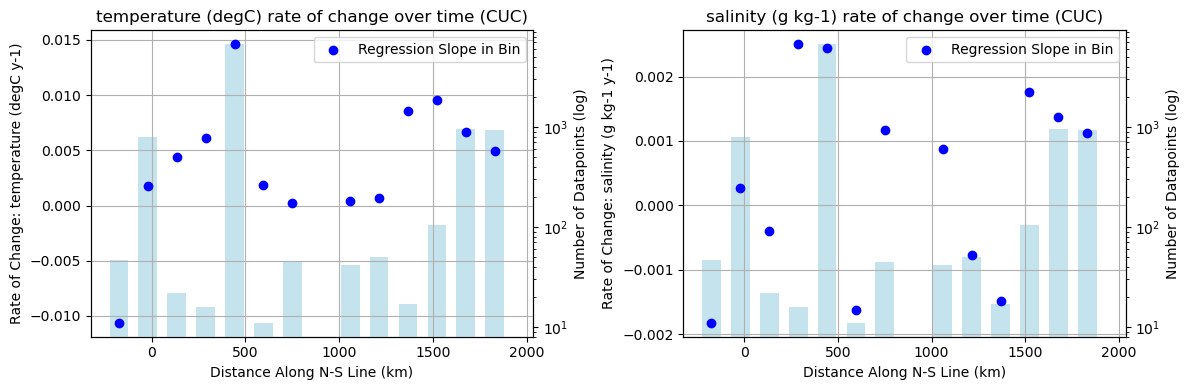

In [10]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))
plot_ratediff_NS('temperature (degC)', 'CUC', 0)
plot_ratediff_NS('salinity (g kg-1)', 'CUC', 1)
plt.tight_layout()

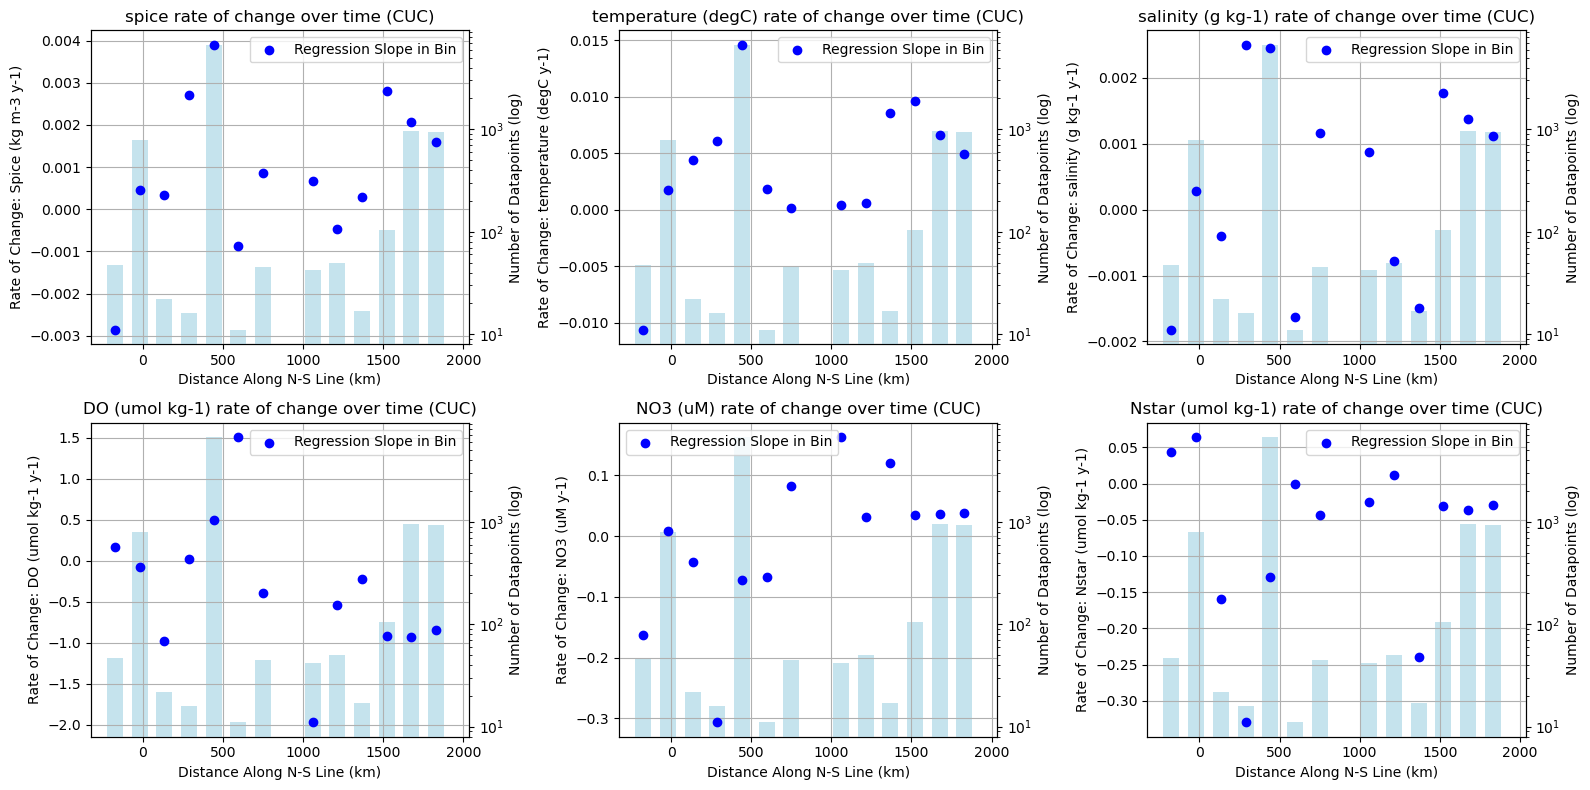

In [11]:
fig, ax = plt.subplots(2,3, figsize=(16, 8))
plot_ratediff_NS('spice', 'CUC', (0,0))
plot_ratediff_NS('temperature (degC)', 'CUC', (0,1))
plot_ratediff_NS('salinity (g kg-1)', 'CUC', (0,2))
plot_ratediff_NS('DO (umol kg-1)', 'CUC', (1,0))
plot_ratediff_NS('NO3 (uM)', 'CUC', (1,1))
plot_ratediff_NS('Nstar (umol kg-1)', 'CUC', (1,2))
plt.tight_layout()

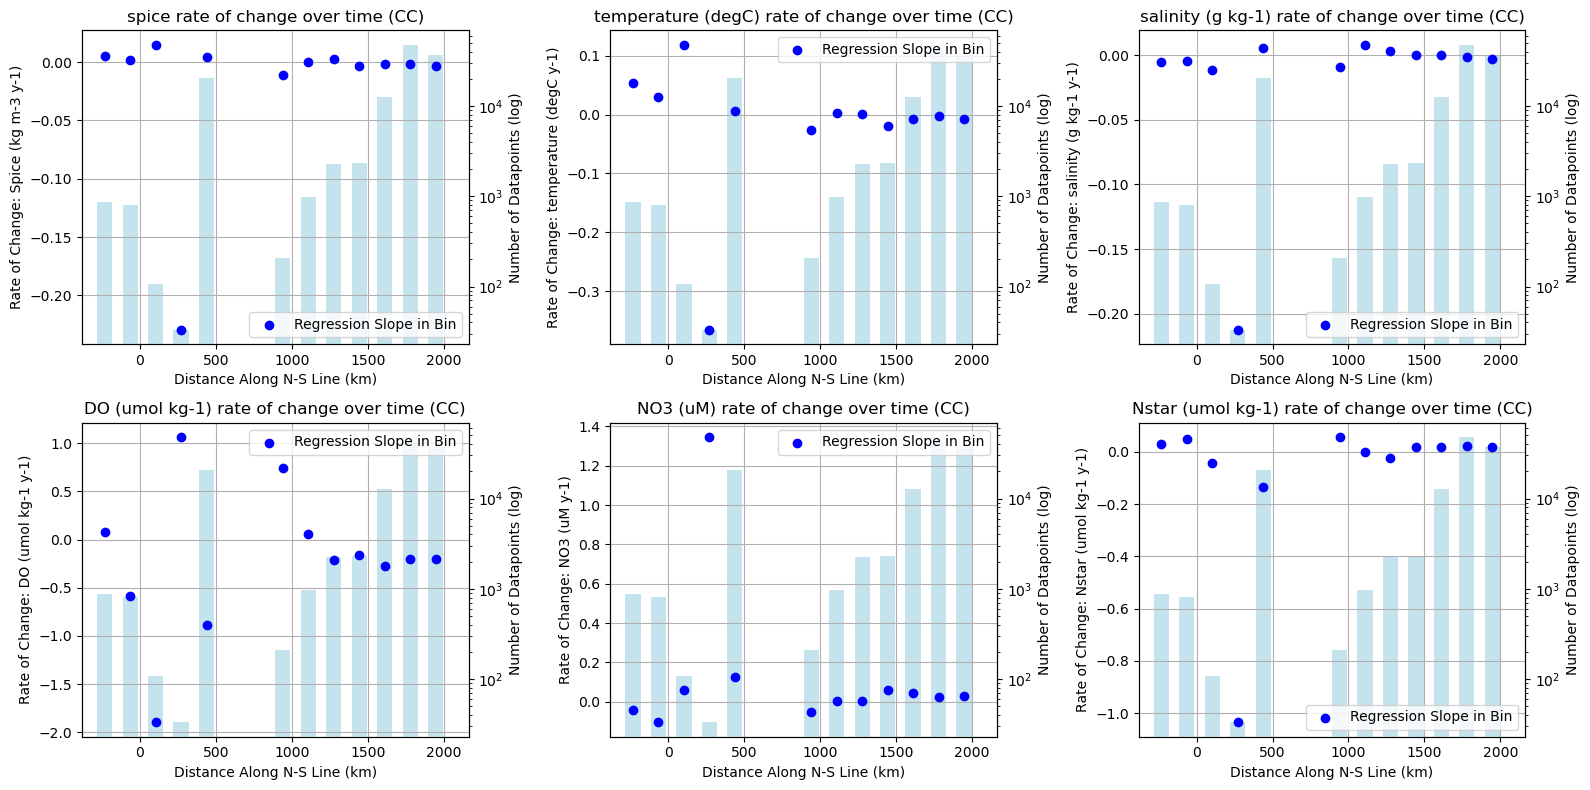

In [12]:
fig, ax = plt.subplots(2,3, figsize=(16, 8))
plot_ratediff_NS('spice', 'CC', (0,0))
plot_ratediff_NS('temperature (degC)', 'CC', (0,1))
plot_ratediff_NS('salinity (g kg-1)', 'CC', (0,2))
plot_ratediff_NS('DO (umol kg-1)', 'CC', (1,0))
plot_ratediff_NS('NO3 (uM)', 'CC', (1,1))
plot_ratediff_NS('Nstar (umol kg-1)', 'CC', (1,2))
plt.tight_layout()

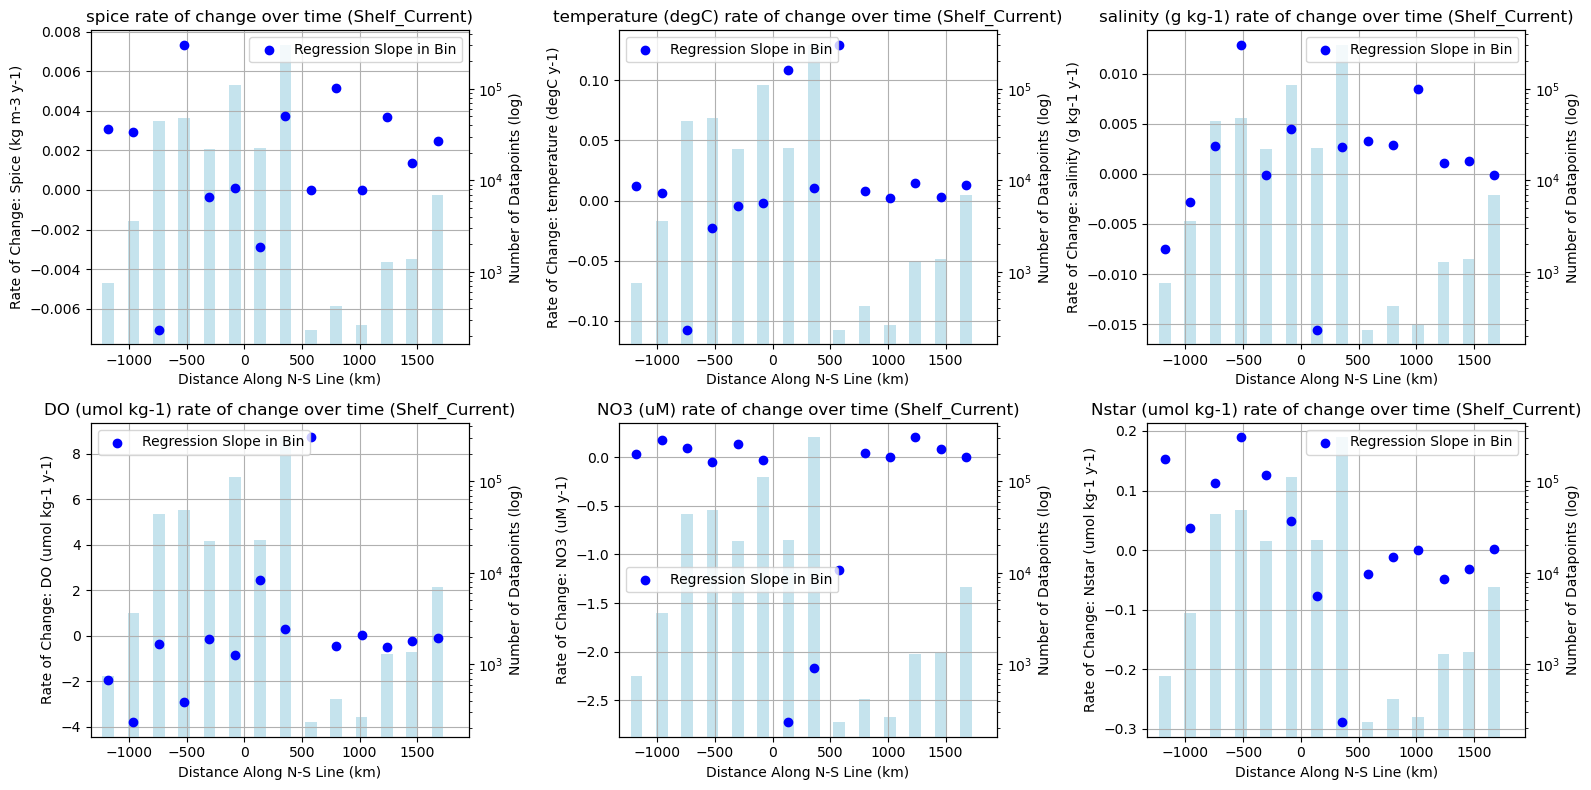

In [13]:
fig, ax = plt.subplots(2,3, figsize=(16, 8))
plot_ratediff_NS('spice', 'Shelf_Current', (0,0))
plot_ratediff_NS('temperature (degC)', 'Shelf_Current', (0,1))
plot_ratediff_NS('salinity (g kg-1)', 'Shelf_Current', (0,2))
plot_ratediff_NS('DO (umol kg-1)', 'Shelf_Current', (1,0))
plot_ratediff_NS('NO3 (uM)', 'Shelf_Current', (1,1))
plot_ratediff_NS('Nstar (umol kg-1)', 'Shelf_Current', (1,2))
plt.tight_layout()

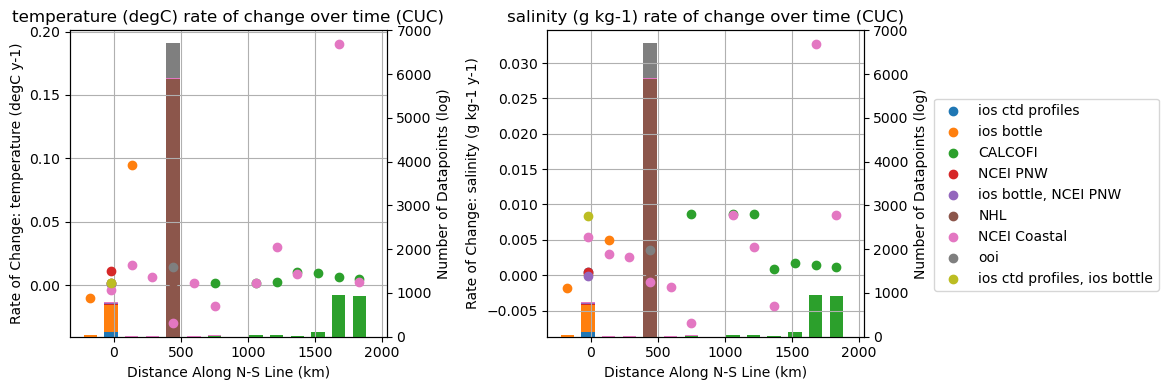

In [14]:
def plot_ratediff_NS_source(var_string, current_string, subplot_pos, final_plot=False):

    if current_string=='CUC':
        obs_used = obs_cuc
    elif current_string=='Shelf_Current':
        obs_used = obs_shelf
    elif current_string=='CC':
        obs_used = obs_cc
    else:
        raise Exception("Invalid Current Name") 
    
    max_NS = max(obs_used['NS_distance'])
    min_NS = min(obs_used['NS_distance'])

    sources = obs_used['source'].unique() 
    
    bins_NS = np.linspace(min_NS, max_NS, num=15)
    rates_NS_binned = np.zeros((len(bins_NS)-1, len(sources)))
    num_datapoints = np.zeros((len(bins_NS)-1, len(sources)))
    for s in range(len(sources)):
        source = sources[s]
        for i in range(len(bins_NS)-1):
            low_bound = bins_NS[i]
            high_bound = bins_NS[i+1]
        
            obs_bin = obs_used[(obs_used['NS_distance'] <= high_bound) & (obs_used['NS_distance'] >= low_bound) & (obs_used['source'] == source)]
            if len(obs_bin)==0:
                num_datapoints[i,s] = 0
                rates_NS_binned[i,s] = np.nan
                continue
            
            x = obs_bin['year']
            y = obs_bin[var_string]
            
            idx = np.isfinite(x) & np.isfinite(y)
            m, b = np.polyfit(x[idx], y[idx], 1)
            num_datapoints[i,s] = len(idx)
            rates_NS_binned[i,s] = m
    
    bins_NS_tiled = np.tile(bins_NS, (len(sources), 1)).T
    x, y = bins_NS_tiled[:-1,:], rates_NS_binned
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    colors = colors[:len(sources)]
    
    ax2 = ax[subplot_pos].twinx()
    # ax2.bar(bins_NS[:-1], num_datapoints.sum(axis=1), width=100, label='N', color='lightblue', alpha=0.7, zorder=3)
    # ax2.set_yscale('log')
    ax2.set_ylabel('Number of Datapoints (log)')
    ax2.set_ylim([0,7000])

    bottom = np.zeros(num_datapoints.shape[0])
    
    for i in range(len(sources)):
        p = ax2.bar(bins_NS[:-1], num_datapoints[:,i], width=100, label=sources[i], color=colors[i], bottom=bottom, zorder=3)
        bottom += num_datapoints[:,i]
        
    
    # Loop over rows and plot each as a separate series
    for i in range(x.shape[1]):
        ax[subplot_pos].scatter(x[:,i], y[:,i], label=sources[i], color=colors[i], zorder=5)
    
    ax[subplot_pos].set_xlim([min(bins_NS)-150, max(bins_NS)+50])
    ax[subplot_pos].set_xlabel('Distance Along N-S Line (km)')
    if var_string == 'spice':
        ax[subplot_pos].set_ylabel('Rate of Change: Spice (kg m-3 y-1)')
    else:
        ax[subplot_pos].set_ylabel("Rate of Change: " + var_string[:-1] + ' y-1' + var_string[-1:])
    
    ax[subplot_pos].set_title(f'{var_string} rate of change over time ({current_string})')
    ax[subplot_pos].grid()
    if final_plot:
        ax[subplot_pos].legend(bbox_to_anchor=(1.2, 0.8))
    
    ax2.set_zorder(1)
    ax[subplot_pos].set_zorder(2)
    ax[subplot_pos].patch.set_alpha(0)

    return None

fig, ax = plt.subplots(1,2, figsize=(12, 4))
plot_ratediff_NS_source('temperature (degC)', 'CUC', 0)
plot_ratediff_NS_source('salinity (g kg-1)', 'CUC', 1, True)
plt.tight_layout()

In [43]:
def plot_ratediff_NS_CI(var_string, current_string, subplot_pos):

    if current_string=='CUC':
        obs_used = obs_cuc
    elif current_string=='Shelf_Current':
        obs_used = obs_shelf
    elif current_string=='CC':
        obs_used = obs_cc
    else:
        raise Exception("Invalid Current Name") 
    # Set ylims so they are consistent across currents
    ylim_dict = {'spice':[-0.015,0.02], 'temperature (degC)': [-0.1,0.2], 'salinity (g kg-1)':[-0.02,0.015], 'DO (umol kg-1)':[-4,12.5], 'NO3 (uM)':[-3,1.5], 'TA-DIC (uM)':[-7.5,22]}
    
    max_NS = max(obs_used['NS_distance'])
    min_NS = min(obs_used['NS_distance'])
    
    rates_NS_binned = []
    coeff_list = []
    upper_CI = []
    lower_CI = []
    num_yrs = []
    bins_NS = np.linspace(min_NS, max_NS, num=10)
    for i in range(len(bins_NS)-1):
        low_bound = bins_NS[i]
        high_bound = bins_NS[i+1]
    
        obs_bin = obs_used[(obs_used['NS_distance'] <= high_bound) & (obs_used['NS_distance'] >= low_bound)]
        if len(obs_bin)==0:
            num_yrs += [0]
            lower_CI += [np.nan]
            upper_CI += [np.nan]
            rates_NS_binned += [np.nan]
            continue
        
        x = obs_bin['year']
        y = obs_bin[var_string]
        
        idx = np.isfinite(x) & np.isfinite(y)
        # m, b = np.polyfit(x[idx], y[idx], 1)
        # print(x[idx])

        X = x[idx]
        Y = y[idx] 
        num_yrs += [max(X)-min(X)]

        
        # Calculate weights based on the inverse of the variance of the errors
        errors = Y - np.mean(Y)
        error_variance = np.var(errors)
        
        if error_variance==0:
            weights=1
        else:
            weights = 1 / error_variance
        
        # Fit weighted least squares regression model
        X = sm.add_constant(X)
        model = sm.WLS(Y, X, weights=weights)
        results = model.fit()
        
        # Print regression results
        # print(results.summary())

        r = results.rsquared    # rsquared parameter

        try:
            m = results.params[1]   # slope of regression
        except:
            m = results.params[0] 

        # Default 95% CI
        ci = results.conf_int(alpha=0.05)  # alpha = 1 - confidence level
        # Named access
        ci.columns = ["lower", "upper"]

        if 'year' in ci.index:
            slope_ci = ci.loc['year']
        else:
            # Key does not exist
            print("Column 'const' is missing.")
            slope_ci = [np.nan, np.nan]

        lower_CI += [slope_ci[0]]
        upper_CI += [slope_ci[1]]

        if m==0:
            rates_NS_binned += [np.nan]
        else:
            rates_NS_binned += [m]

    
    rates_NS_binned = np.array(rates_NS_binned)

    ax2 = ax[subplot_pos].twinx()
   
    ax2.bar(bins_NS[:-1], num_yrs, width=130, label='N', color='lightblue', alpha=0.7, zorder=3)
    ax2.set_ylabel('Number of Years in Regression')
    
    # ax[subplot_pos].scatter(bins_NS[:-1], rates_NS_binned, label='Regression Slope in Bin', color='b', s=0.5, zorder=5)
    # ax[subplot_pos].fill_between(bins_NS[:-1], upper_CI, lower_CI)
    
    yerr = [upper_CI-rates_NS_binned, rates_NS_binned-lower_CI]
    ax[subplot_pos].errorbar(bins_NS[:-1], rates_NS_binned, yerr=yerr, fmt='.', ms=7, c='darkblue', label='95% CI')
    
    ax[subplot_pos].set_xlim([min(bins_NS)-150, max(bins_NS)+50])
    ax[subplot_pos].set_xlabel('Distance Along N-S Line (km)')
    if var_string == 'spice':
        ax[subplot_pos].set_ylabel('Rate of Change: Spice (kg m-3 y-1)')
    else:
        ax[subplot_pos].set_ylabel("Rate of Change: " + var_string[:-1] + ' y-1' + var_string[-1:])
    
    ax[subplot_pos].set_title(f'{var_string} rate of change over time ({current_string})')
    ax[subplot_pos].grid()
    ax[subplot_pos].legend()
    ax[subplot_pos].axhline(y=0, color='black', linewidth=1, linestyle='-', zorder=2)
    
    if var_string in list(ylim_dict.keys()):
        ax[subplot_pos].set_ylim(ylim_dict[var_string])
    
    ax2.set_zorder(1)
    ax[subplot_pos].set_zorder(3)
    ax[subplot_pos].patch.set_alpha(0)

    return None

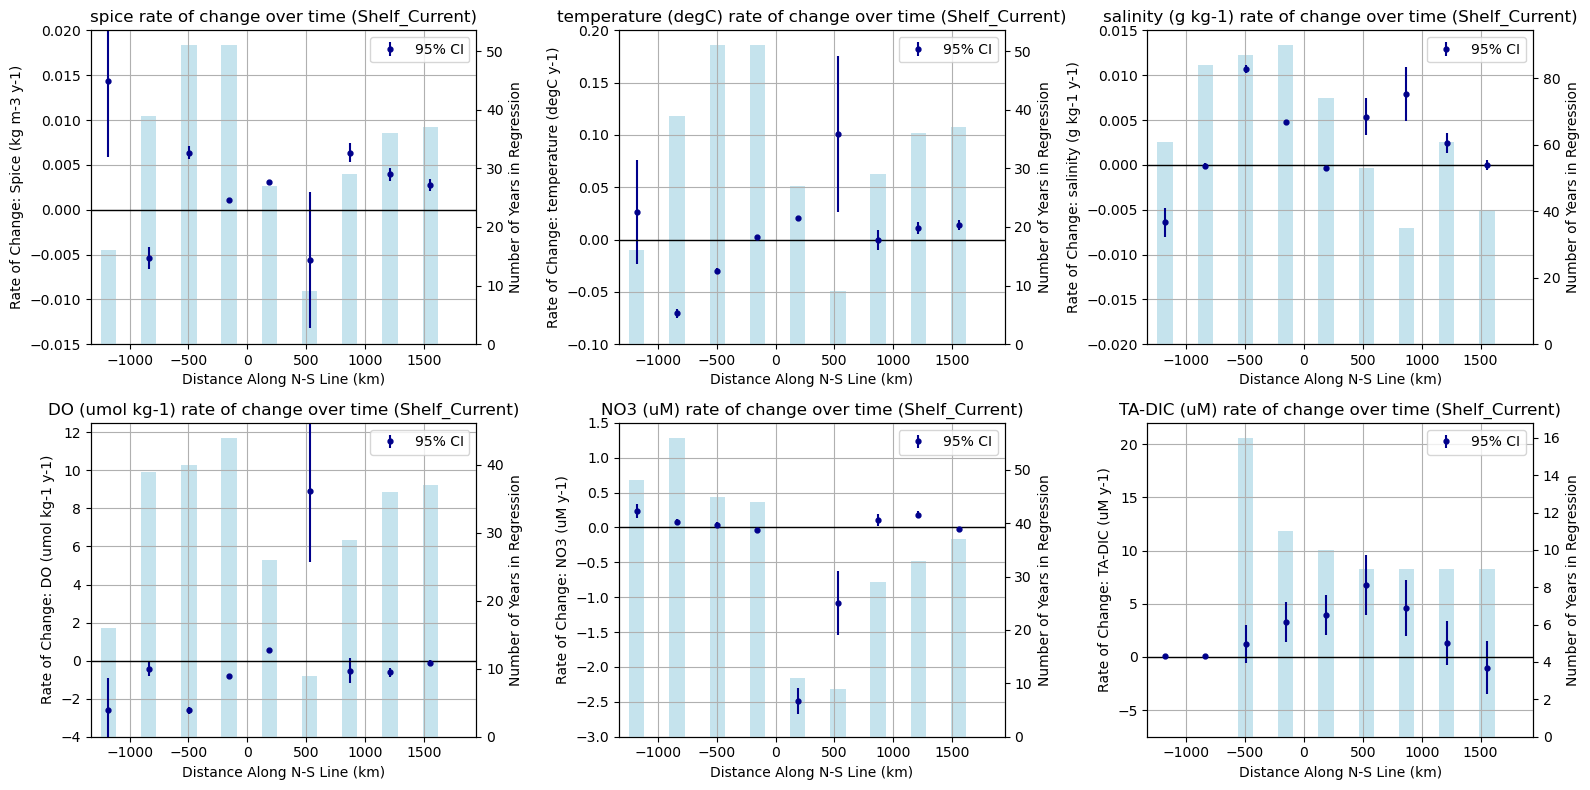

In [44]:
fig, ax = plt.subplots(2,3, figsize=(16, 8))
plot_ratediff_NS_CI('spice', 'Shelf_Current', (0,0))
plot_ratediff_NS_CI('temperature (degC)', 'Shelf_Current', (0,1))
plot_ratediff_NS_CI('salinity (g kg-1)', 'Shelf_Current', (0,2))
plot_ratediff_NS_CI('DO (umol kg-1)', 'Shelf_Current', (1,0))
plot_ratediff_NS_CI('NO3 (uM)', 'Shelf_Current', (1,1))
plot_ratediff_NS_CI('TA-DIC (uM)', 'Shelf_Current', (1,2))
plt.tight_layout()

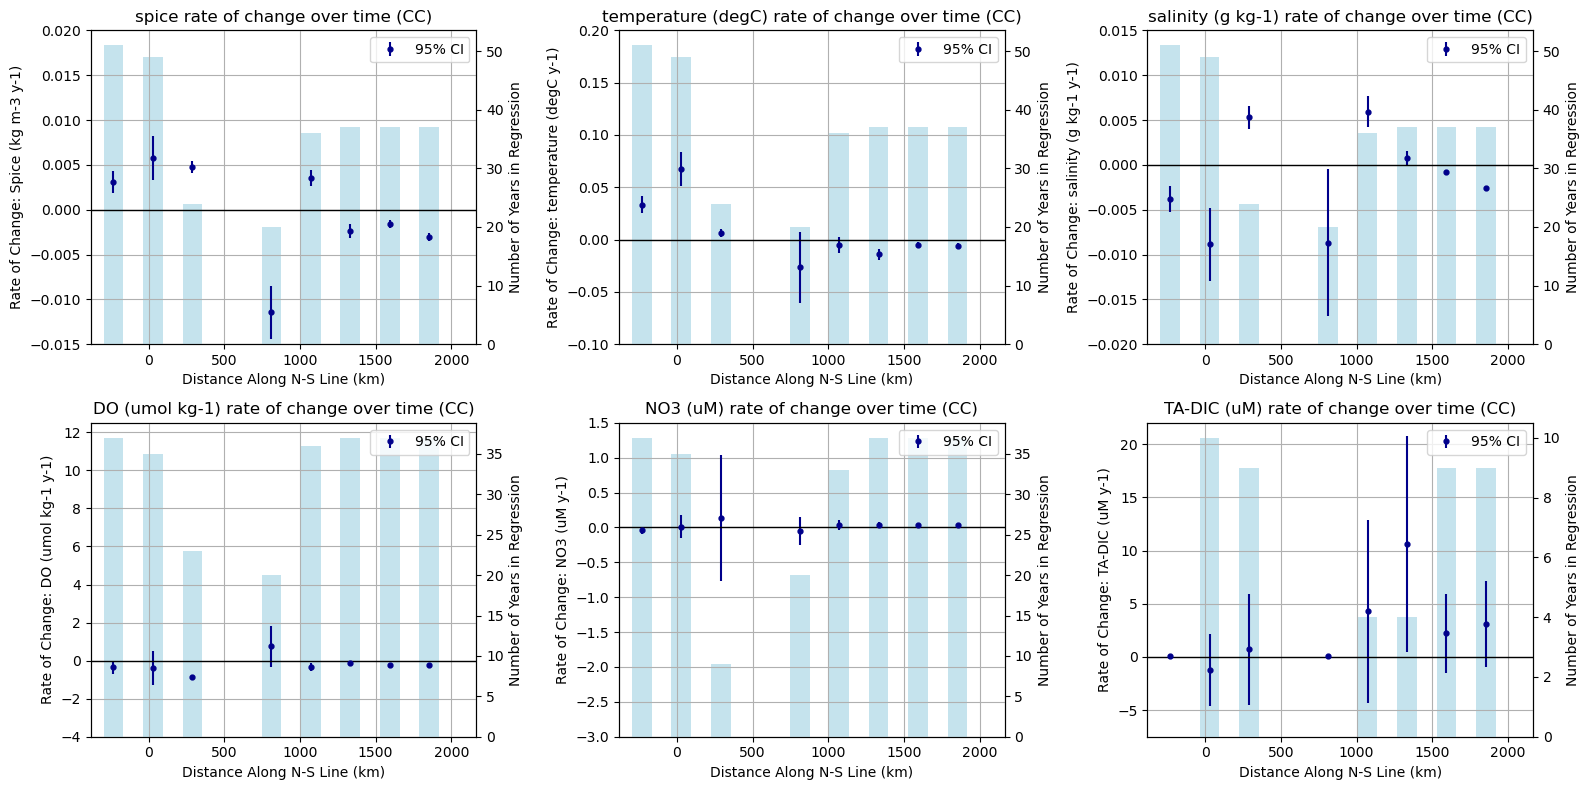

In [45]:
fig, ax = plt.subplots(2,3, figsize=(16, 8))
plot_ratediff_NS_CI('spice', 'CC', (0,0))
plot_ratediff_NS_CI('temperature (degC)', 'CC', (0,1))
plot_ratediff_NS_CI('salinity (g kg-1)', 'CC', (0,2))
plot_ratediff_NS_CI('DO (umol kg-1)', 'CC', (1,0))
plot_ratediff_NS_CI('NO3 (uM)', 'CC', (1,1))
plot_ratediff_NS_CI('TA-DIC (uM)', 'CC', (1,2))
plt.tight_layout()

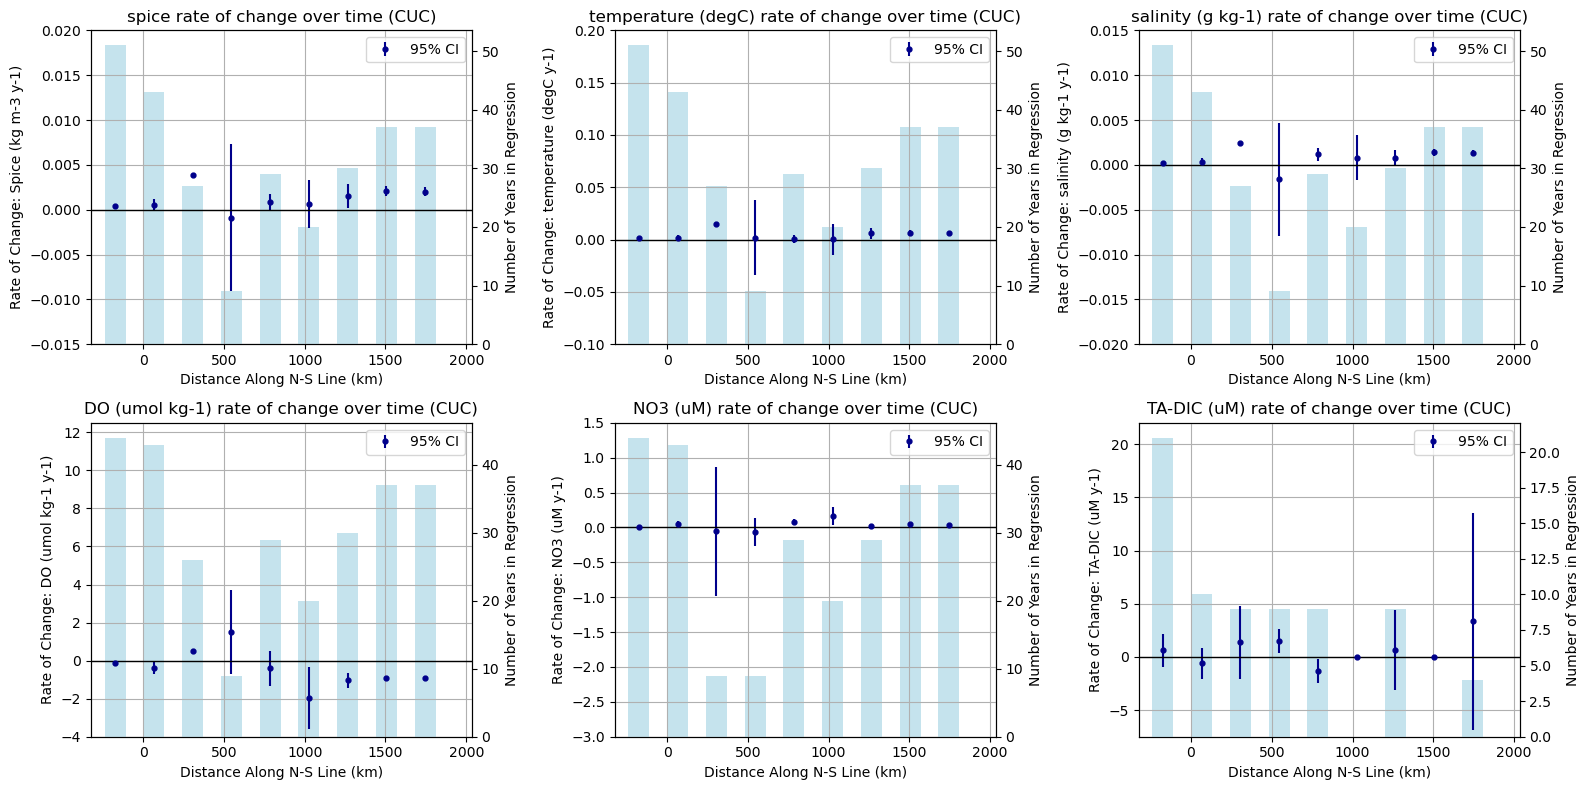

In [46]:
fig, ax = plt.subplots(2,3, figsize=(16, 8))
plot_ratediff_NS_CI('spice', 'CUC', (0,0))
plot_ratediff_NS_CI('temperature (degC)', 'CUC', (0,1))
plot_ratediff_NS_CI('salinity (g kg-1)', 'CUC', (0,2))
plot_ratediff_NS_CI('DO (umol kg-1)', 'CUC', (1,0))
plot_ratediff_NS_CI('NO3 (uM)', 'CUC', (1,1))
plot_ratediff_NS_CI('TA-DIC (uM)', 'CUC', (1,2))
plt.tight_layout()

In [ ]:
print(obs[obs["values"] > 1000]["values"])
